In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# # задаём уровень значимости
alpha = 0.05 

In [4]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

In [5]:
data = pd.read_csv('hotels.csv')

### Анализ данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [8]:
data.describe(include="object")

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


Резюме по данным:
1. Всего в таблице 386803 отзывов и 17 столбцов
2. Присутсвуют пропуски в столбцах lat и lng
3. Отзывы имеют разброс от 2.5 до 10
4. Больше всего посетителей из Великобритании, а также самый популярный отель назодится в Британии
5. Самая популярная дата ревью восьмого февраля 2017 года
6. Самые популярные отзывы No negative No positive. Возможно отзывы по умолчанию

 ### Работа с пропусками


In [7]:
# Проверяем кол-во пропусков
null_addresses = data[['lat', 'lng']].isnull().mean()

null_addresses

lat    0.006329
lng    0.006329
dtype: float64

In [8]:
missing_coordinates = data.groupby('hotel_address').filter(lambda x: x['lat'].isnull().any() or x['lng'].isnull().any())
print('Список пропущенных адрессов отелей')
print(missing_coordinates['hotel_address'].value_counts())


Список пропущенных адрессов отелей
hotel_address
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    496
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            421
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       285
4 rue de la P pini re 8th arr 75008 Paris France               224
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         182
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          172
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               141
Bail n 4 6 Eixample 08010 Barcelona Spain                      113
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria            112
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria             63
23 Rue Damr mont 18th arr 75018 Paris France                    47
Hasenauerstra e 12 19 D bling 1190 Vienna Austria               44
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria        40
Paragonstra e 1 11 Simmering 1110 Vienna Austria                34
20 Rue De La 

In [9]:
# Создаем список всех адрессов с пропусками
missing_list = list(missing_coordinates['hotel_address'].unique())

geolocator = Nominatim(user_agent="booking project")
# С помошью библиотеки geopy получим список недостающих координат
hotels_coordinates = dict()

for hotel in missing_list:
        address = ' '.join(hotel.split()[-3:])
        location = geolocator.geocode(address)
        hotels_coordinates[hotel] = (location.latitude, location.longitude)


print(hotels_coordinates)

{'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': (48.2083537, 16.3725042), '23 Rue Damr mont 18th arr 75018 Paris France': (48.8534951, 2.3483915), 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': (48.2083537, 16.3725042), 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': (48.2083537, 16.3725042), '4 rue de la P pini re 8th arr 75008 Paris France': (48.8588897, 2.3200410217200766), 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': (48.2083537, 16.3725042), 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': (48.2083537, 16.3725042), 'Bail n 4 6 Eixample 08010 Barcelona Spain': (41.3828939, 2.1774322), 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': (48.2083537, 16.3725042), 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': (48.2083537, 16.3725042), 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': (48.2083537, 16.3725042), 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': (48.2083537, 16.3725042), '20 Rue De La Ga t 14th arr 7

In [10]:
def get_location(row):
    if row['hotel_address'] in missing_list:
        row['lat'] = hotels_coordinates[row['hotel_address']][0]
        row['lng'] = hotels_coordinates[row['hotel_address']][1]
    return row

# Заполняем пропуски в таблице
data = data.apply(get_location, axis=1)

In [11]:
print(data[['lat', 'lng']].isnull().mean())

lat    0.0
lng    0.0
dtype: float64


### Работа с признаками

#### 1. Дата
   

In [12]:
data['review_date'] = pd.to_datetime(data['review_date'])

In [13]:
# Разбиваем дату на 3 колонки для полноты данных
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['review_day'] = data['review_date'].dt.day_of_week

# Убираем колонку со старой датой
data.drop(["review_date"], axis=1, inplace=True)

data[['review_year', 'review_month', 'review_day']]

,review_year,review_month,review_day
0,2016,2,4
1,2017,1,3
2,2016,10,1
3,2015,9,1
4,2016,3,5
...,...,...,...
386798,2017,4,2
386799,2017,2,0
386800,2016,2,6
386801,2017,5,6


#### 2. День от ревью

In [14]:
# Оставим только кол-во дней без текста
data['days_since_review'] = data['days_since_review'].apply(lambda value: int(value.split()[0])) 

data['days_since_review']

0         531
1         203
2         289
3         681
4         516
         ... 
386798    106
386799    171
386800    543
386801     74
386802    363
Name: days_since_review, Length: 386803, dtype: int64

#### 3. Комментарии к отзывам

In [15]:
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [16]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.downloader.download('vader_lexicon')
analyzer_pos = SentimentIntensityAnalyzer()
analyzer_neg = SentimentIntensityAnalyzer()

# Преобразуем отзывы в числовой эквивалент
data['negative_review'] = data['negative_review'].apply(lambda rev: analyzer_neg.polarity_scores(rev)['compound'])
data['positive_review'] = data['positive_review'].apply(lambda rev: analyzer_pos.polarity_scores(rev)['compound'])


print(data[['negative_review', 'positive_review']].describe())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alexd/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


       negative_review  positive_review
count    386803.000000    386803.000000
mean          0.108346         0.530013
std           0.436910         0.450875
min          -0.998100        -0.983200
25%          -0.177900         0.353500
50%           0.000000         0.708900
75%           0.557400         0.883400
max           0.996400         0.999300


#### 4. Национальность

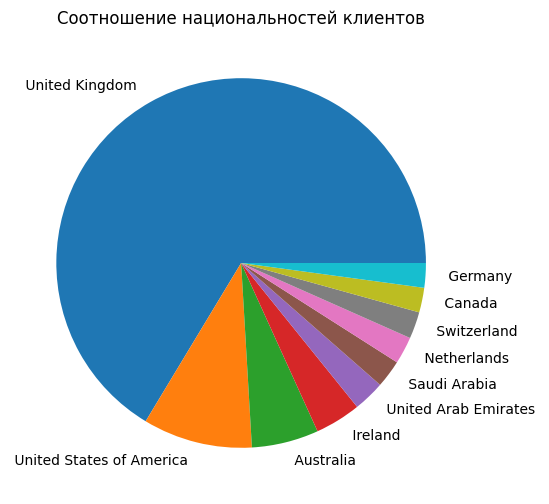

In [17]:
nationalities = data['reviewer_nationality'].value_counts()[:10]

plt.figure(figsize=(6,6)) # Set figure size
plt.pie(nationalities, labels=nationalities.keys())
plt.title('Соотношение национальностей клиентов')
plt.show()

 Из графика видно что наибольшая часть отзывов оставлена жителями Великобритании. Больше всего путешествуют жители стран с высоким уровнем экономики.

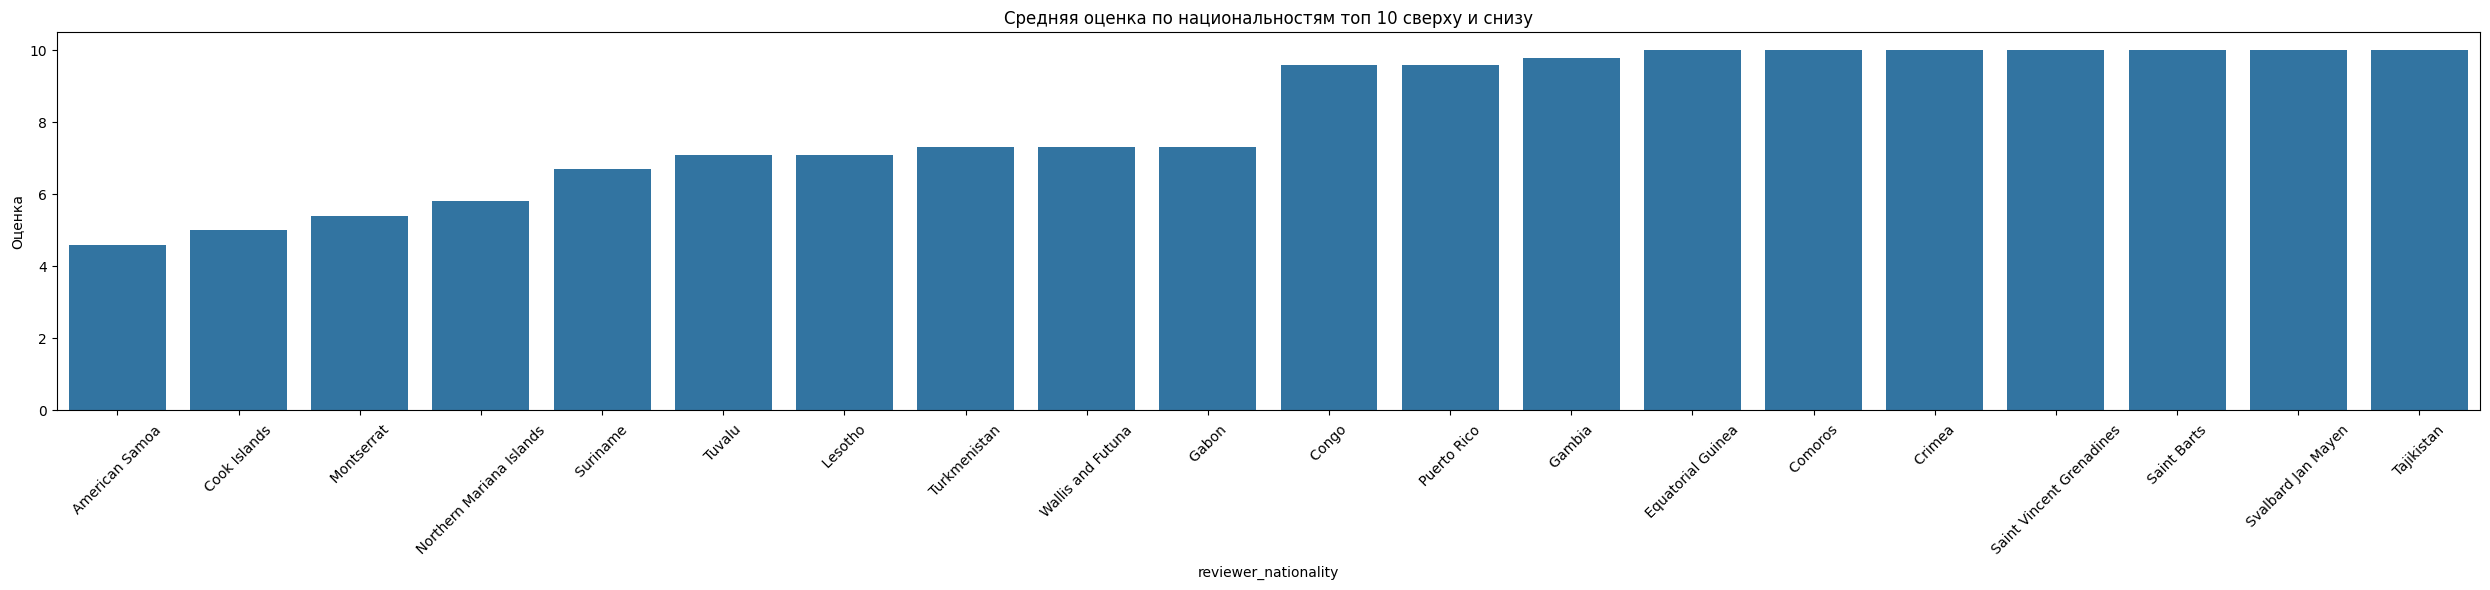

In [16]:
nationality_reviews = data.groupby('reviewer_nationality')['reviewer_score'].median().sort_values()

top_reviews = pd.concat([nationality_reviews[:10], nationality_reviews[-10:]], axis=0)

fig = plt.figure(figsize = (25, 6))
sns.barplot(
    x=top_reviews.keys(),
    y=top_reviews.values
)
plt.title('Средняя оценка по национальностям топ 10 сверху и снизу')
plt.ylabel('Оценка')
plt.xticks(rotation=45)
plt.tight_layout()

Как видно из графика самые высокие и самые низкие оценки ставят жители из бедных стран, возможно из-за малого кол-ва путешественников из этих стран

In [18]:
# Разобьем признак на несколько признаков с помощью бинарного енкодера
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.drop(["reviewer_nationality"], axis=1, inplace=True)


#### 6. Теги

In [19]:
tags_lst = list()

# Функция для заполнения списка всеми тегами
def set_tags(value: str):
    array = value[1:-1].split(', ')
    tags_lst.extend(array)
# Проход по всем тегам из данных 
for value in data['tags'].values:
    set_tags(value)

# Счетчик значений для списка
tags_counter = Counter(tags_lst)
print('Кол-во уникальных тэгов:', len(tags_counter.keys()))
print('Топ 9 популярных тегов:', tags_counter.most_common(9))

Кол-во уникальных тэгов: 2368
Топ 9 популярных тегов: [("' Leisure trip '", 313593), ("' Submitted from a mobile device '", 230778), ("' Couple '", 189212), ("' Stayed 1 night '", 145373), ("' Stayed 2 nights '", 100263), ("' Solo traveler '", 81235), ("' Stayed 3 nights '", 72000), ("' Business trip '", 61989), ("' Group '", 49088)]


Среди топ тэгов можно выделить такие категории как:
1. Тип путешествия - Leisure trip, Business trip
2. С какого устройства было запощено ревью - Submitted from a mobile device
3. Кол-во ночей в отеле
4. Кол-во путешествующих персон - Solo traveler, Couple, Group

In [20]:
# Функция заполнения признака тэга
def tagsEncoding(tag, tags):
    if tag in tags:
        return 1
    return 0

# Выделим среди тегов топ 9
most_common_tags = tags_counter.most_common(9)
# Для каждого тэга из топ 9 создаем признак
for tag in most_common_tags:
    tag_name = tag[0][2:-2]
    data[tag_name] = data['tags'].apply(lambda tags: tagsEncoding(tag_name, tags))

# Уберем остальные тэги
data.drop(["tags"], axis=1, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   average_score                               386803 non-null  float64
 3   hotel_name                                  386803 non-null  object 
 4   negative_review                             386803 non-null  float64
 5   review_total_negative_word_counts           386803 non-null  int64  
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  float64
 8   review_total_positive_word_counts           386803 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 

##### 6.1 Тип поездки

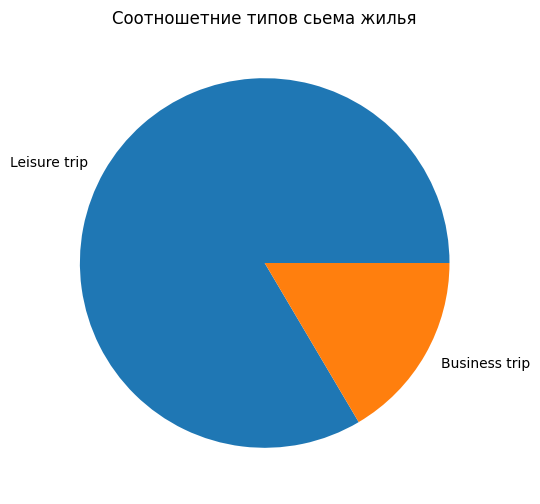

In [26]:
leisure_type = data[data['Leisure trip'] == 1]['Leisure trip'].sum()
business_type = data[data['Business trip'] == 1]['Business trip'].sum()

vacation_type = pd.DataFrame({
    'type': [leisure_type, business_type],
    
}, index=['Leisure trip', 'Business trip'])

plt.figure(figsize=(6,6))
plt.pie(vacation_type['type'], labels=vacation_type.index)
plt.title('Соотношетние типов сьема жилья')
plt.show()

Из графика видно что большинство отзывов от клиентов, приехавших на отдых.

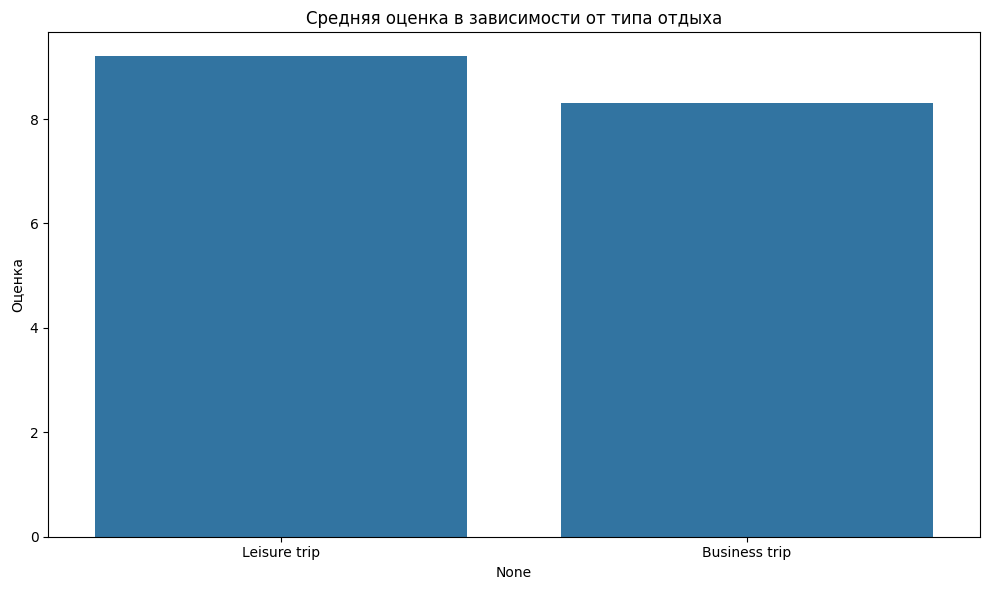

In [27]:
leisure_type_rating = data[data['Leisure trip'] == 1]['reviewer_score'].median()
business_type_rating = data[data['Business trip'] == 1]['reviewer_score'].median()

vacation_type_rating = pd.DataFrame({
    'rating': [leisure_type_rating, business_type_rating],
    
}, index=['Leisure trip', 'Business trip'])

fig = plt.figure(figsize = (10, 6))
sns.barplot(
    x=vacation_type.index,
    y=vacation_type_rating['rating']
)
plt.title('Средняя оценка в зависимости от типа отдыха')
plt.ylabel('Оценка')
plt.tight_layout();


По графику можно заметить, что зачастую люди после отдыха оставляют оценку выше, чем после бизнес поездки.

Проверим гипотезу, что величина оценки после отдыхе выше чем после бизнес поездки?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): величина оценки после отдыха ($μ_1$) статистически меньше либо равен величине оценки после рабочей поездки ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): величина оценки после отдыха ($μ_1$) статистически больше, чем величина оценки после рабочей поездки ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [28]:
leisure_review = data.loc[data['Leisure trip']==1, 'reviewer_score']
business_review = data.loc[data['Business trip']==1, 'reviewer_score']

# проводим тест Шапиро-Уилка
print('После отдыха:')
result = stats.shapiro(leisure_review)
decision_normality(result[1])

print('Рабочая поездка:')
result = stats.shapiro(business_review)
decision_normality(result[1])

После отдыха:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Рабочая поездка:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


/var/data/python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 313593.
  res = hypotest_fun_out(*samples, **kwds)
/var/data/python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 61989.
  res = hypotest_fun_out(*samples, **kwds)


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Оценка»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [29]:
_, p = stats.mannwhitneyu(leisure_review, business_review, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Действительно, после отдыха клиенты ставят оценки выше, чем после бизнес путешествия

##### 6.2 С какого устройства оставлен отзыв

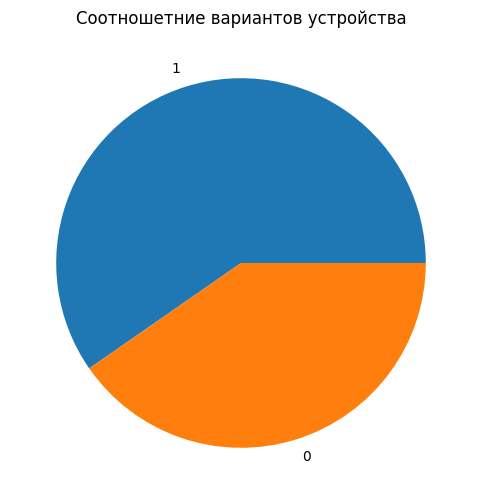

In [30]:
mobile_type = data['Submitted from a mobile device'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(mobile_type, labels=mobile_type.index)
plt.title('Соотношетние вариантов устройства')
plt.show()

Чаще всего отзывы отсавляют с телефона, возможно прямо из отеля

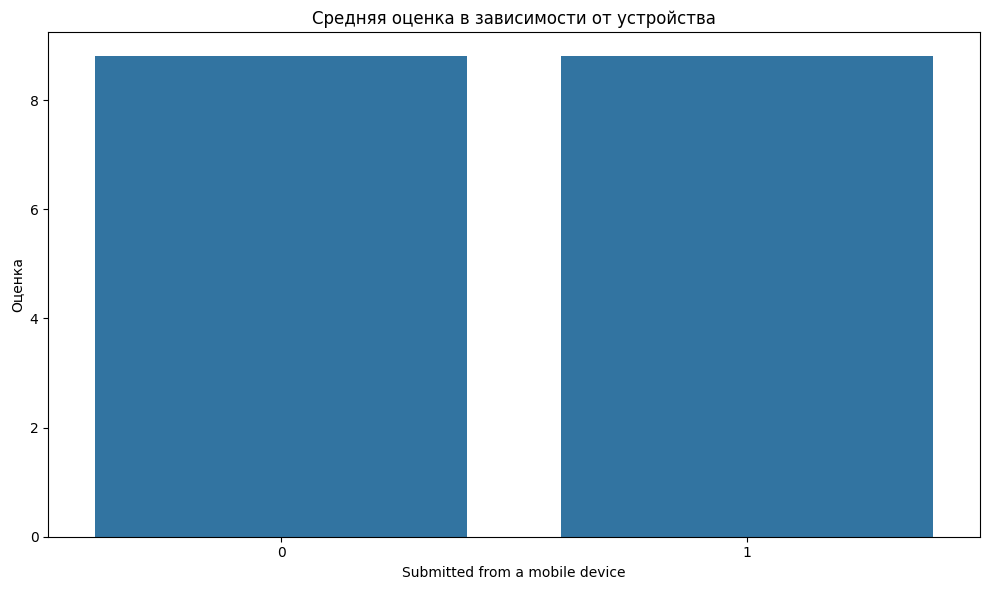

In [31]:
mobile_type = data.groupby('Submitted from a mobile device')['reviewer_score'].median()

fig = plt.figure(figsize = (10, 6))
sns.barplot(
    x=mobile_type.keys(),
    y=mobile_type.values
)
plt.title('Средняя оценка в зависимости от устройства')
plt.ylabel('Оценка')
plt.tight_layout();

Из графика видно, что устройство не влияет на оценку

Проверим гипотезу, что с телефона оценки такие же как и с других устройств. 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): величина оценки клиента с мобильного ($μ_1$) статистически равна величине оценки с другого устройства ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): величина оценки клиента с мобильного ($μ_1$) статистически больше или меньше, чем величина оценки с другого устройства ($μ_2$).

$$ H_1 : μ_1 <> μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [32]:
mobile_review = data.loc[data['Submitted from a mobile device']==1, 'reviewer_score']
other_review = data.loc[data['Submitted from a mobile device']==0, 'reviewer_score']

# проводим тест Шапиро-Уилка
print('С телефона:')
result = stats.shapiro(mobile_review)
decision_normality(result[1])

print('С ПК:')
result = stats.shapiro(other_review)
decision_normality(result[1])

С телефона:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
С ПК:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


/var/data/python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 230778.
  res = hypotest_fun_out(*samples, **kwds)
/var/data/python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 156025.
  res = hypotest_fun_out(*samples, **kwds)


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Рейтинг»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [33]:
# проводим тест
_, p = stats.mannwhitneyu(mobile_review, other_review)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Несмотря на то, что на графике оценки были одинаковы статистически с телефона оценки не равны оценкам с других устройств

##### 6.3 Кол-во ночей

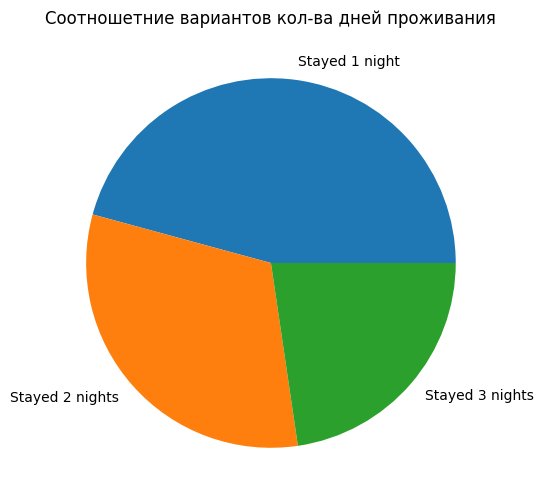

In [34]:
one = data[data['Stayed 1 night'] == 1]['Stayed 1 night'].sum()
two = data[data['Stayed 2 nights'] == 1]['Stayed 2 nights'].sum()
three = data[data['Stayed 3 nights'] == 1]['Stayed 3 nights'].sum()

stay_type = pd.DataFrame({
    'type': [one, two, three],
    
}, index=['Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights'])

plt.figure(figsize=(6,6))
plt.pie(stay_type['type'], labels=stay_type.index)
plt.title('Соотношетние вариантов кол-ва дней проживания')
plt.show()


Чаще всего отель бронировался для одного человека.

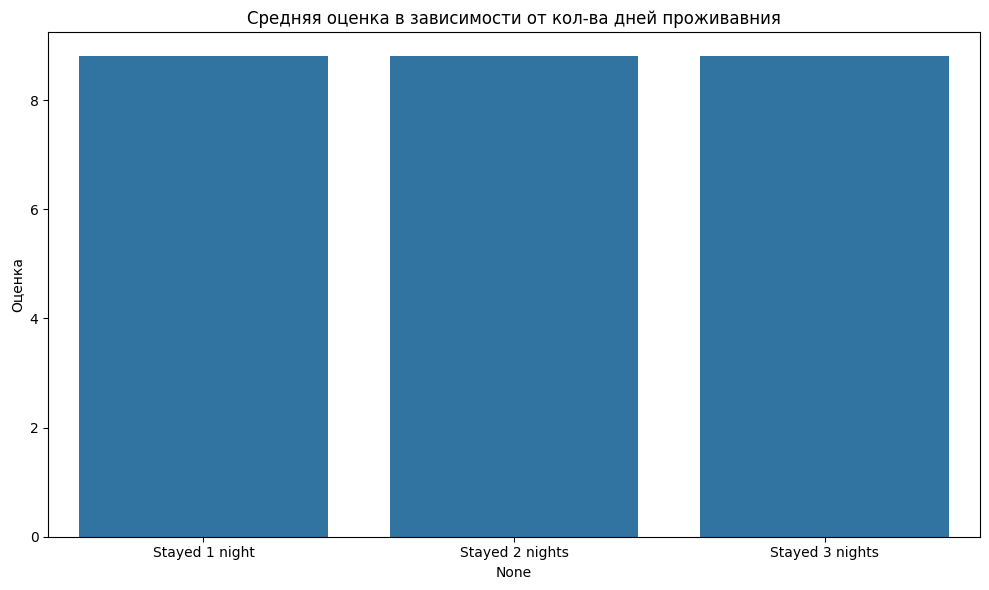

In [35]:
one_rating = data[data['Stayed 1 night'] == 1]['reviewer_score'].median()
two_rating = data[data['Stayed 2 nights'] == 1]['reviewer_score'].median()
three_rating = data[data['Stayed 3 nights'] == 1]['reviewer_score'].median()

stay_rating = pd.DataFrame({
    'rating': [one_rating, two_rating, three_rating],
    
}, index=['Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights'])

fig = plt.figure(figsize = (10, 6))
sns.barplot(
    x=stay_rating.index,
    y=stay_rating['rating']
)
plt.title('Средняя оценка в зависимости от кол-ва дней проживавния')
plt.ylabel('Оценка')
plt.tight_layout();


График показывает, что кол-во дней не влият оценку

Проверим влияет ли кол-во ночей проживания на оценку?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: величина оценки не зависит от кол-ва ночей: 1 ночь ($μ_1$), 2 ночи ($μ_2$), 3 ночи ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: величина оценки зависит от кол-ва ночей: 1 ночь ($μ_1$), 2 ночи ($μ_2$), 3 ночи ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [36]:
one_review = data.loc[data['Stayed 1 night']==1, 'reviewer_score']
two_review = data.loc[data['Stayed 2 nights']==1, 'reviewer_score']
three_review = data.loc[data['Stayed 3 nights']==1, 'reviewer_score']

# проводим тест Шапиро-Уилка
print('Для 1 ночи:')
result = stats.shapiro(one_review)
decision_normality(result[1])

print('Для 2 ночей:')
result = stats.shapiro(two_review)
decision_normality(result[1])

print('Для 3 ночей:')
result = stats.shapiro(three_review)
decision_normality(result[1])


Для 1 ночи:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2 ночей:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 3 ночей:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


/var/data/python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 145373.
  res = hypotest_fun_out(*samples, **kwds)
/var/data/python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100263.
  res = hypotest_fun_out(*samples, **kwds)
/var/data/python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 72000.
  res = hypotest_fun_out(*samples, **kwds)


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Оценка»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [37]:
_, p = stats.kruskal(one_review, two_review, three_review)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Несмотря на показания графика итоговая оценка зависит от кол-ва ночей проведенных в отеле

##### 6.4 Кол-во человек

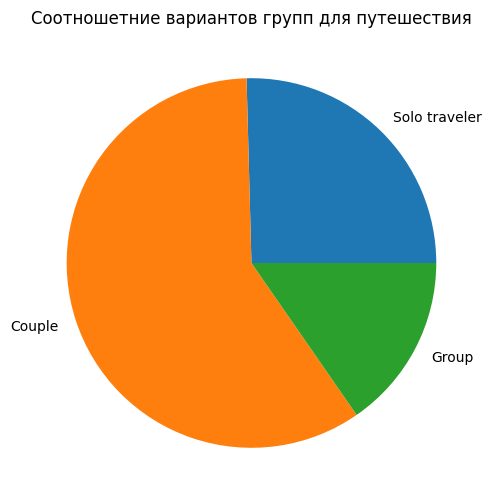

In [38]:
solo = data[data['Solo traveler'] == 1]['Solo traveler'].sum()
couple = data[data['Couple'] == 1]['Couple'].sum()
group = data[data['Group'] == 1]['Group'].sum()

party_type = pd.DataFrame({
    'type': [solo, couple, group],
    
}, index=['Solo traveler', 'Couple', 'Group'])

plt.figure(figsize=(6,6))
plt.pie(party_type['type'], labels=party_type.index)
plt.title('Соотношетние вариантов групп для путешествия')
plt.show()


Больше всего люди путешествуют парой

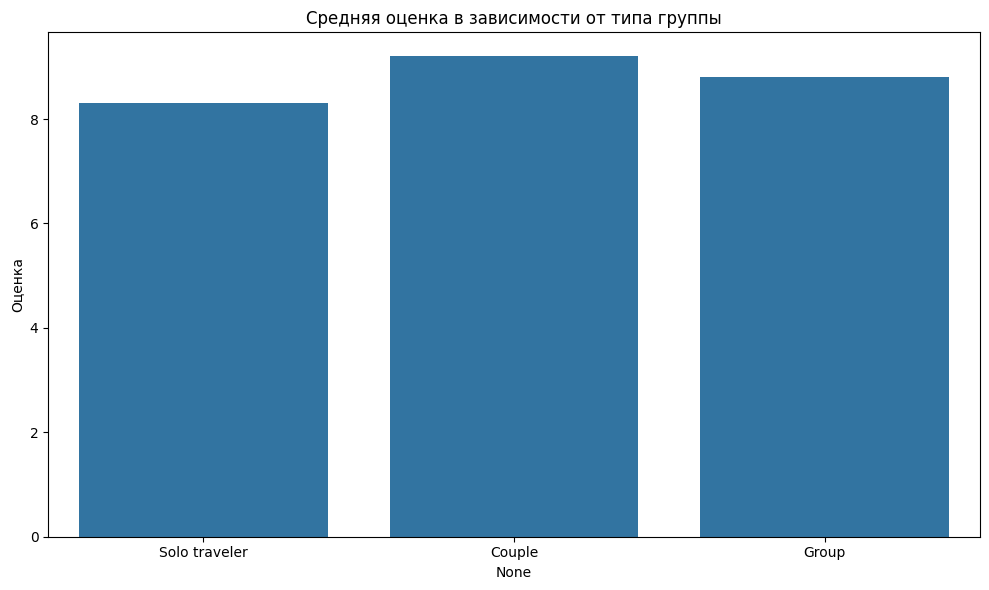

In [39]:
solo_rating = data[data['Solo traveler'] == 1]['reviewer_score'].median()
couple_rating = data[data['Couple'] == 1]['reviewer_score'].median()
group_rating = data[data['Group'] == 1]['reviewer_score'].median()

party_rating = pd.DataFrame({
    'rating': [solo_rating, couple_rating, group_rating],
    
}, index=['Solo traveler', 'Couple', 'Group'])

fig = plt.figure(figsize = (10, 6))
sns.barplot(
    x=party_rating.index,
    y=party_rating['rating']
)
plt.title('Средняя оценка в зависимости от типа группы')
plt.ylabel('Оценка')
plt.tight_layout();

Как видно из графика, оценки не одинаковы, чаще всего довольны отелем клиенты приехавшие парой. Люди приехавшие одни стаят оценки ниже других.

#### Определим важность признаков

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   average_score                               386803 non-null  float64
 3   hotel_name                                  386803 non-null  object 
 4   negative_review                             386803 non-null  float64
 5   review_total_negative_word_counts           386803 non-null  int64  
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  float64
 8   review_total_positive_word_counts           386803 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 

In [21]:
# Уберем все не числовые признаки
data.drop(["hotel_address", "hotel_name"], axis=1, inplace=True)

In [22]:
# Выделим данные для определения их полезности
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 


<Axes: >

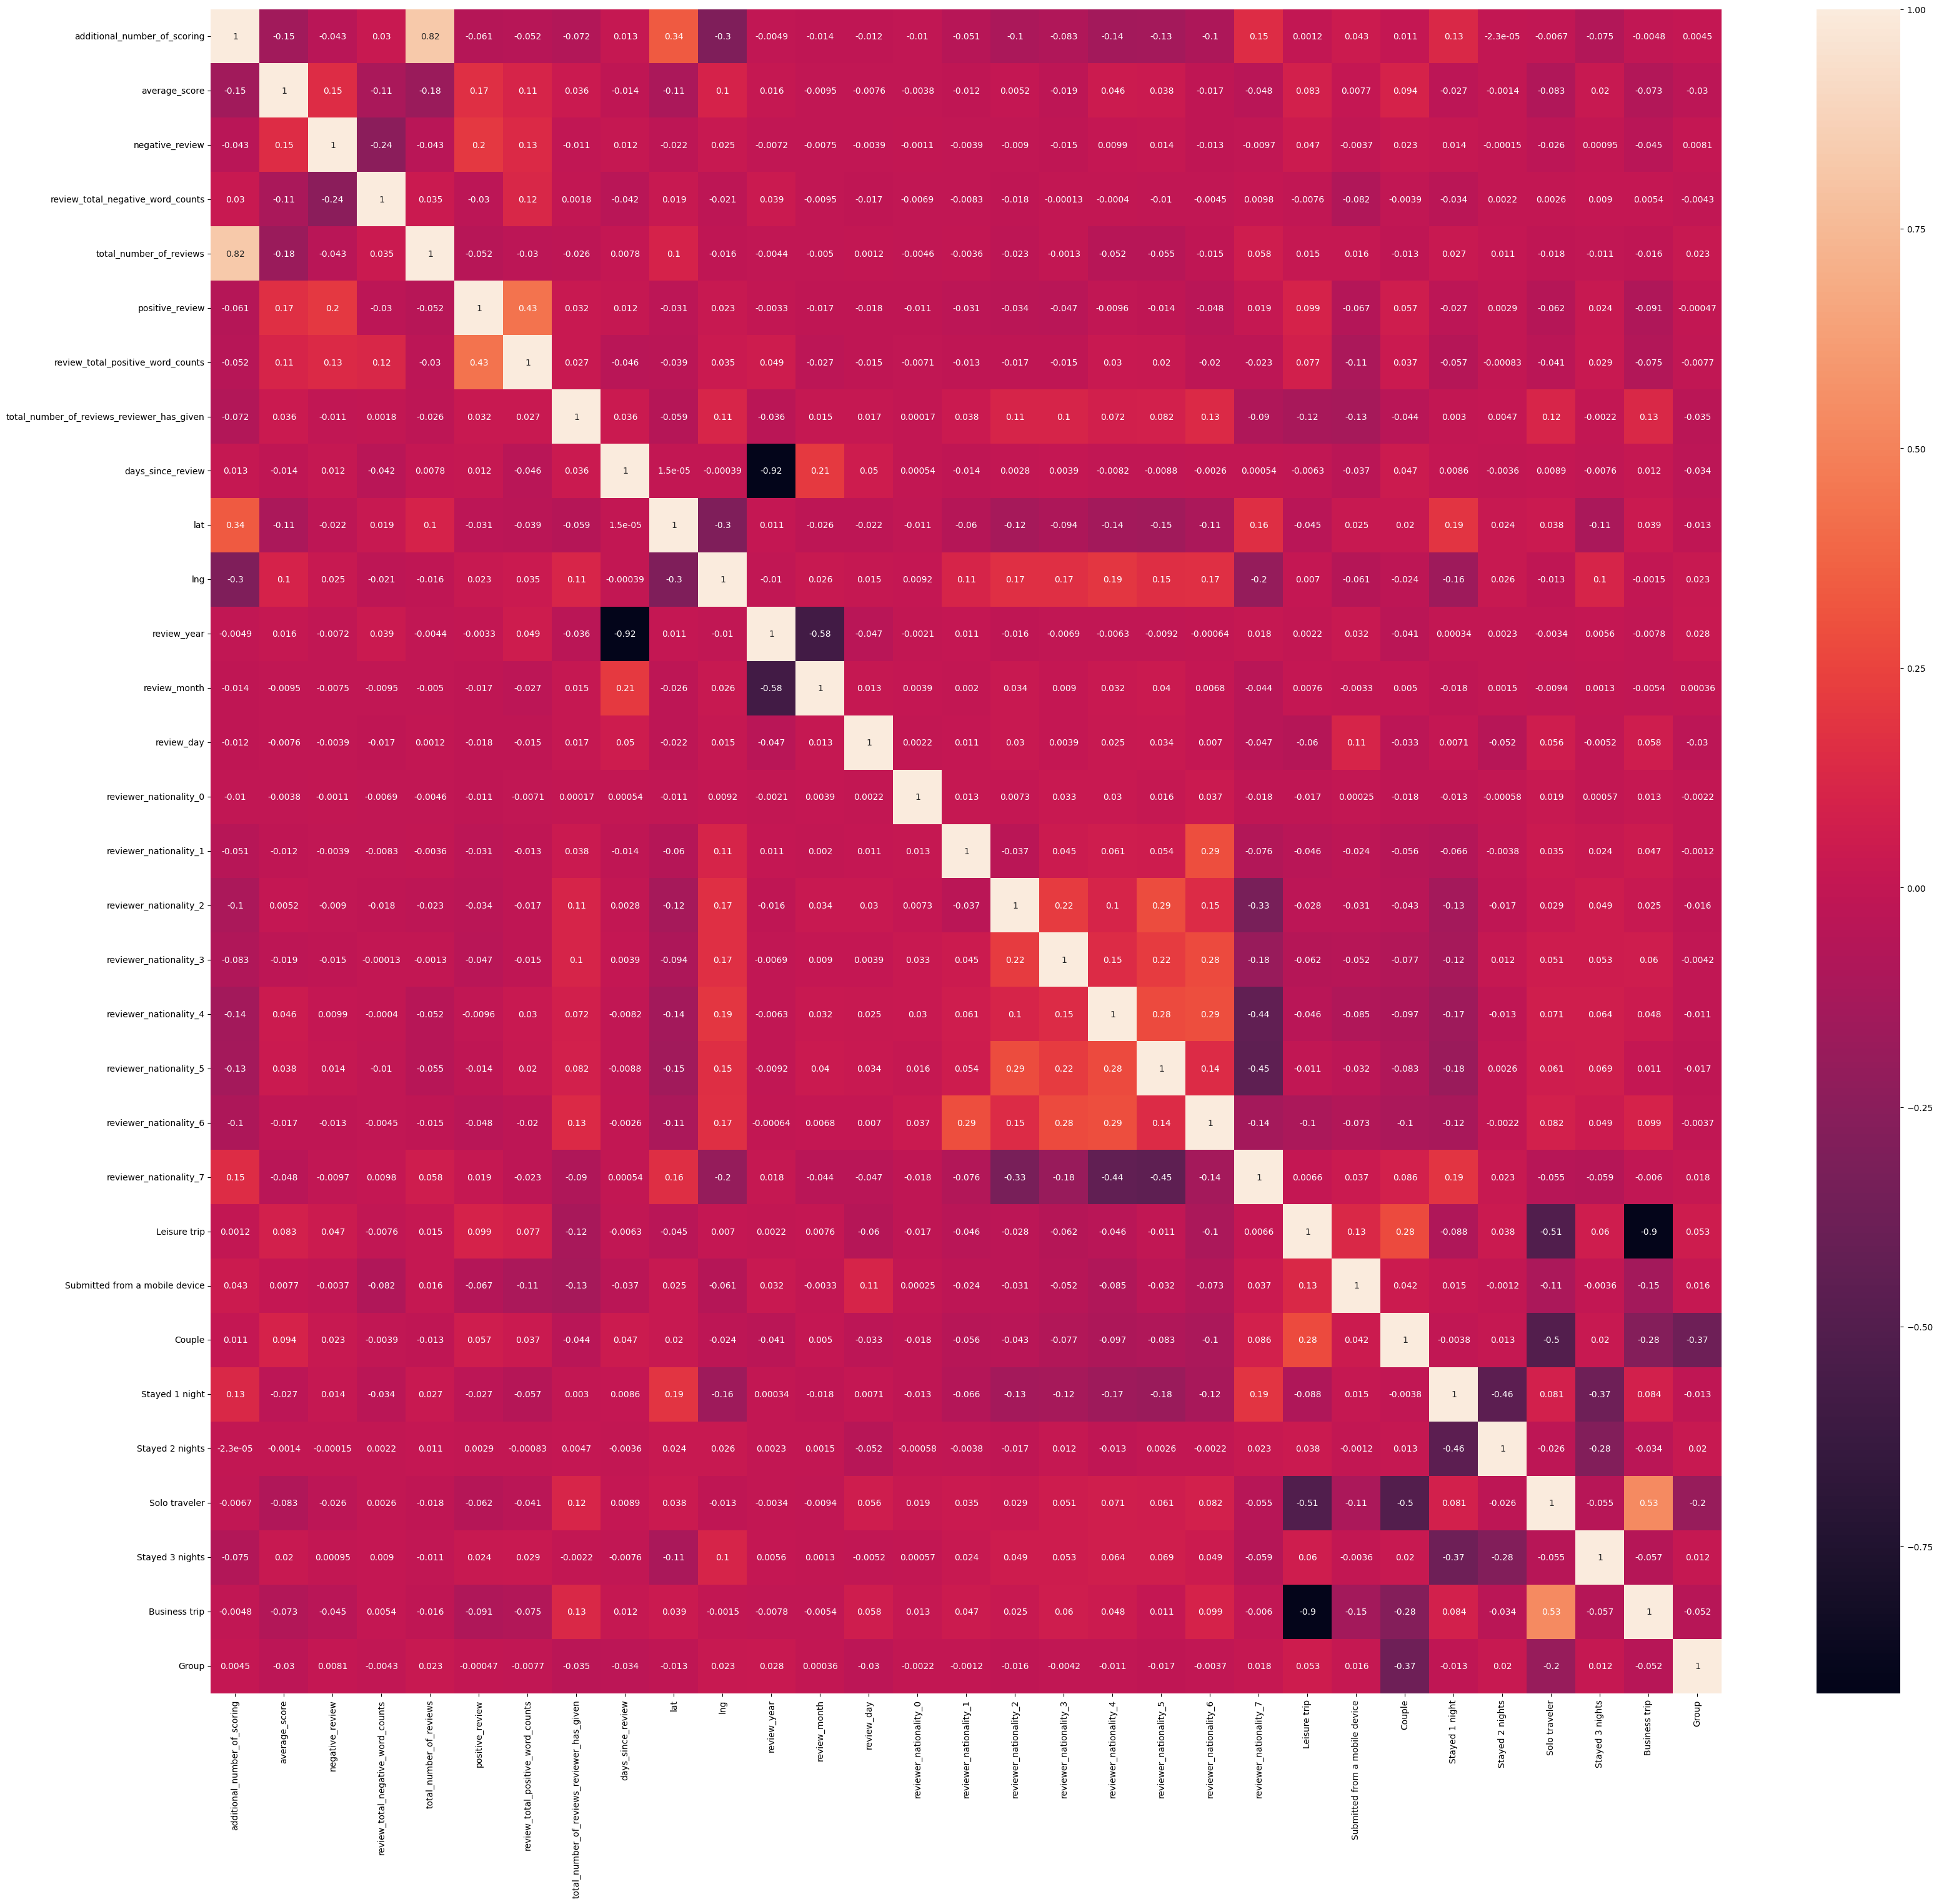

In [23]:
fig_, ax_ = plt.subplots(figsize=(39, 35))

sns.heatmap(X.corr(), annot=True, ax=ax_)

In [24]:
# Уберем колонки которые имеют высокую корреляцию
X.drop(["Business trip", "review_year", 'review_total_positive_word_counts'], axis=1, inplace=True)

In [25]:
# Выделим категориальные и числовые признаки
num_cols = ['average_score', 'days_since_review','positive_review', 'negative_review', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
cat_cols = ['Submitted from a mobile device', 'Couple', 'Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights', 'Group', 'Solo traveler', 'review_month', 'review_day','average_score', 'lat', 'lng', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7']

In [30]:
X[cat_cols].describe()

,Submitted from a mobile device,Couple,Stayed 1 night,Stayed 2 nights,Stayed 3 nights,Group,Solo traveler,review_month,review_day,average_score,lat,lng,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,0.596629,0.489169,0.375832,0.259209,0.186141,0.126907,0.210016,6.489125,2.721975,8.397231,49.433402,2.892457,0.003087,0.049079,0.185467,0.195596,0.262736,0.323322,0.184290,0.706895
std,0.490575,0.499883,0.484338,0.438201,0.389221,0.332869,0.407320,3.351116,2.084538,0.547881,3.460968,4.666368,0.055474,0.216034,0.388676,0.396659,0.440121,0.467745,0.387721,0.455187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.200000,41.328376,-0.369758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,8.100000,48.213305,-0.143372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000,8.400000,51.499981,0.019886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,5.000000,8.800000,51.516288,4.841163,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,6.000000,9.800000,52.400181,16.429233,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

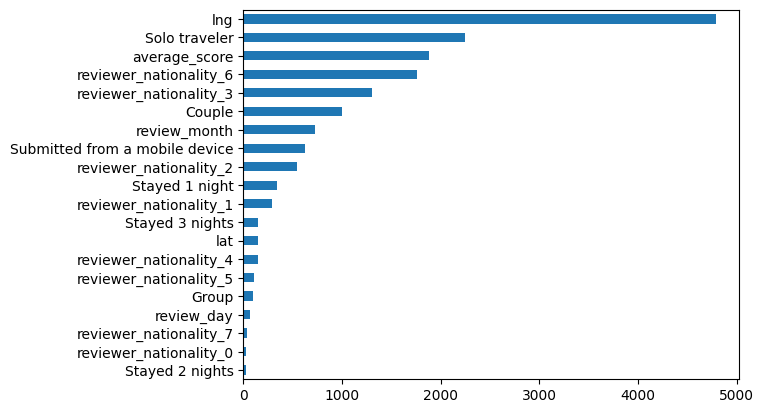

In [31]:
y=y.astype('int')
X['lng'] = X['lng'].apply(lambda lng: abs(lng))
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

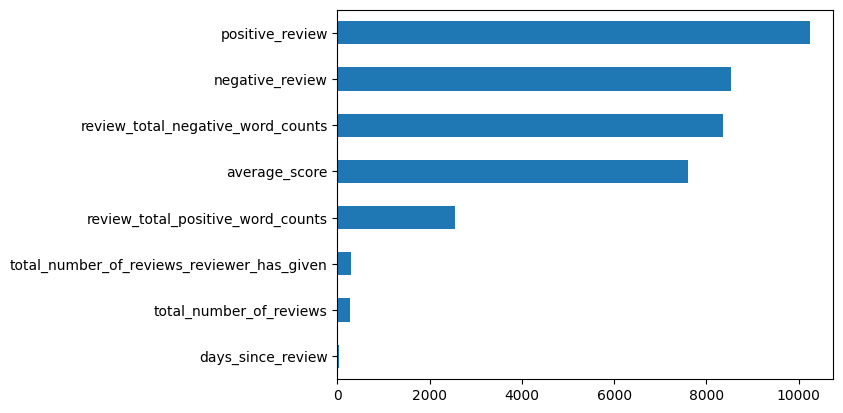

In [32]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [26]:
# Удалим значения, которые слабо влияют на результат
X.drop(["days_since_review", 'Stayed 2 nights', "review_day", 'Group', 'lat', 'Stayed 3 nights', 'reviewer_nationality_0'], axis=1, inplace=True)

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   negative_review                             386803 non-null  float64
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   positive_review                             386803 non-null  float64
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 7   lng                                         386803 non-null  float64
 8   review_month                                386803 non-null  int32  
 9   reviewer_nationality_1                      386803 non-null  int64  
 

In [28]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [30]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12801086872923315
